In [19]:
# ===============================================================
# CELL 1 — Basic Setup (RUN THIS FIRST)
# ===============================================================

import os
import time
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from pathlib import Path

import pennylane as qml

# ---------------- Device ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Torch Device:", DEVICE)

# ---------------- Quantum Device ----------------
n_qubits = 4
n_layers = 2
N_COMPONENTS = 5

if DEVICE.type == "cuda":
    try:
        dev = qml.device("lightning.gpu", wires=n_qubits, shots=None)
        print("Using PennyLane device: lightning.gpu")
    except:
        dev = qml.device("default.qubit", wires=n_qubits, shots=None)
        print("Fallback to PennyLane device: default.qubit")
else:
    dev = qml.device("default.qubit", wires=n_qubits, shots=None)
    print("Using PennyLane device: default.qubit")

print("Setup complete.")

Using Torch Device: cpu
Using PennyLane device: default.qubit
Setup complete.


In [20]:
# ===============================================================
# CELL 2 — Data Loading + Feature Engineering
# ===============================================================

# ---------------- Load Data ----------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)

print("Total rows:", len(df))
print("Total reactions:", df["Reaction"].nunique())

# ---------------- Physics Feature Engineering ----------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_nucleon_mass(Z, A):
    return Z * M_p + (A - Z) * M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values

mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values

v_over_c = np.sqrt(np.clip(2 * Ecm / (mu_MeVc2 + epsilon), 0, np.inf))
e2_hbar_c = 1 / 137.035999

df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

# ---------------- S-factor residual ----------------
log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

log10_exp_term = (2 * np.pi * df["eta"]) / LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

# ---------------- Extra Physics Features ----------------
df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"] * df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2, 8, 20, 28, 50, 82, 126])

def magic_dist(arr):
    return np.min(np.abs(arr[:, None] - MAGIC[None, :]), axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)

print("Feature engineering complete.")

Total rows: 3532
Total reactions: 213
Feature engineering complete.


In [21]:
# ===============================================================
# CELL 3 — SAME Reaction Split + Scaling
# ===============================================================

# ---------------- 29 Training Features ----------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# ---------------- Load SAME reaction split from classical run ----------------
BASE_DIR = "mdn_70_10_20_optimized"

train_reacts = pd.read_csv(os.path.join(BASE_DIR, "train_reactions.csv"))["Reaction"].values
val_reacts   = pd.read_csv(os.path.join(BASE_DIR, "val_reactions.csv"))["Reaction"].values
test_reacts  = pd.read_csv(os.path.join(BASE_DIR, "test_reactions.csv"))["Reaction"].values

print("Train reactions:", len(train_reacts))
print("Val reactions:", len(val_reacts))
print("Test reactions:", len(test_reacts))

train_mask = df["Reaction"].isin(train_reacts)
val_mask   = df["Reaction"].isin(val_reacts)
test_mask  = df["Reaction"].isin(test_reacts)

# ---------------- Prepare Data ----------------
X_train_full = df.loc[train_mask | val_mask, features_train].values.astype(np.float32)
y_train_full = df.loc[train_mask | val_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

X_test = df.loc[test_mask, features_train].values.astype(np.float32)
y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

# ---------------- Scaling (same as classical) ----------------
scaler = StandardScaler().fit(X_train_full)

X_train_full_s = scaler.transform(X_train_full)
X_test_s = scaler.transform(X_test)

print("Training samples:", X_train_full_s.shape[0])
print("Test samples:", X_test_s.shape[0])
print("Data ready.")

Train reactions: 149
Val reactions: 21
Test reactions: 43
Training samples: 2847
Test samples: 685
Data ready.


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml
import numpy as np

# =========================================================
# Force Torch default dtype to float32 (IMPORTANT)
# =========================================================
torch.set_default_dtype(torch.float32)

# =========================================================
# Quantum Device
# =========================================================
n_qubits = 4
n_layers = 2
N_COMPONENTS = 5

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dev = qml.device("default.qubit", wires=n_qubits)

# =========================================================
# Quantum Node
# =========================================================
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qnode(weights, inputs):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="X")
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))  # returns tensor


# =========================================================
# QMDN Model
# =========================================================
class QMDN(nn.Module):
    def __init__(self, in_dim, n_components=5, hidden_dim=32):
        super().__init__()

        self.n_components = n_components

        # Classical encoder
        self.encoder = nn.Linear(in_dim, n_qubits)

        # Quantum parameters
        init = 0.01
        self.weight = nn.Parameter(
            init * torch.randn(n_layers, n_qubits, 3, dtype=torch.float32)
        )

        # Classical head
        self.fc1 = nn.Linear(2**n_qubits, hidden_dim)
        self.fc_pi = nn.Linear(hidden_dim, n_components)
        self.fc_mu = nn.Linear(hidden_dim, n_components)
        self.fc_sigma = nn.Linear(hidden_dim, n_components)

    def forward(self, x):

        x = x.float()

        # Encode to quantum angles
        x_enc = torch.tanh(self.encoder(x))

        # Collect quantum features
        q_features = []
        for i in range(x_enc.shape[0]):

            probs = qnode(self.weight, x_enc[i])

            # Ensure correct dtype and device
            probs = probs.to(x.device).float()

            q_features.append(probs)

        q_features = torch.stack(q_features)

        # Classical processing
        h = torch.relu(self.fc1(q_features))

        pi_logits = self.fc_pi(h)
        mu = self.fc_mu(h)
        sigma_raw = self.fc_sigma(h)

        pi = F.softmax(pi_logits, dim=1)
        sigma = F.softplus(sigma_raw) + 1e-6

        return pi, mu, sigma


# =========================================================
# MDN Loss + Entropy Regularization
# =========================================================
def mdn_loss_entropy(pi, mu, sigma, y, lambda_entropy=0.01):

    y = y.float()
    yexp = y.repeat(1, mu.shape[1])

    log_gauss = (
        -0.5 * ((yexp - mu) / sigma) ** 2
        - torch.log(sigma)
        - 0.5 * np.log(2 * np.pi)
    )

    log_mix = torch.logsumexp(torch.log(pi + 1e-12) + log_gauss, dim=1)
    nll = -log_mix.mean()

    entropy = -torch.sum(pi * torch.log(pi + 1e-12), dim=1).mean()

    return nll - lambda_entropy * entropy


print("✅ Clean QMDN defined successfully.")

✅ Clean QMDN defined successfully.


In [30]:
model = QMDN(in_dim=X_train_full_s.shape[1]).to(DEVICE)

sample_batch, _ = next(iter(train_loader))
sample_batch = sample_batch.to(DEVICE)

with torch.no_grad():
    pi, mu, sigma = model(sample_batch)

print("π dtype:", pi.dtype)
print("μ dtype:", mu.dtype)
print("σ dtype:", sigma.dtype)

π dtype: torch.float32
μ dtype: torch.float32
σ dtype: torch.float32


In [13]:
# Required imports for training
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [32]:
# ===============================================================
# QMDN Training — Clean Final Version
# ===============================================================

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# ---------------- Pure MDN NLL ----------------
def mdn_loss(pi, mu, sigma, y):
    y = y.float()
    yexp = y.repeat(1, mu.shape[1])

    log_gauss = (
        -0.5 * ((yexp - mu) / sigma) ** 2
        - torch.log(sigma)
        - 0.5 * np.log(2 * np.pi)
    )

    log_mix = torch.logsumexp(torch.log(pi + 1e-12) + log_gauss, dim=1)
    return -log_mix.mean()


# ---------------- Entropy Regularized Loss ----------------
def mdn_loss_entropy(pi, mu, sigma, y, lambda_entropy=0.05):

    nll = mdn_loss(pi, mu, sigma, y)

    entropy = -torch.sum(pi * torch.log(pi + 1e-12), dim=1).mean()

    return nll - lambda_entropy * entropy


# ---------------- DataLoader ----------------
def make_loader(X, y, batch=64, shuffle=True):
    return DataLoader(
        TensorDataset(
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32)
        ),
        batch_size=batch,
        shuffle=shuffle
    )


# ---------------- Validation Split ----------------
val_size = int(0.1 * len(X_train_full_s))
indices = np.random.permutation(len(X_train_full_s))

train_idx = indices[val_size:]
val_idx   = indices[:val_size]

train_loader = make_loader(X_train_full_s[train_idx],
                           y_train_full[train_idx],
                           batch=64)

val_loader   = make_loader(X_train_full_s[val_idx],
                           y_train_full[val_idx],
                           batch=64,
                           shuffle=False)

test_loader  = make_loader(X_test_s, y_test,
                           batch=64,
                           shuffle=False)


# ---------------- Model ----------------
model = QMDN(in_dim=X_train_full_s.shape[1]).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

MAX_EPOCHS = 100
PATIENCE = 10
LAMBDA_ENTROPY = 0.05

best_val_nll = float("inf")
best_state = None
patience_counter = 0

print("\n🚀 Starting Entropy-Regularized QMDN Training\n")

for epoch in range(MAX_EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0.0
    train_nll  = 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        pi, mu, sigma = model(xb)

        loss = mdn_loss_entropy(pi, mu, sigma, yb,
                                lambda_entropy=LAMBDA_ENTROPY)

        nll  = mdn_loss(pi, mu, sigma, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        train_nll  += nll.item()  * xb.size(0)

    train_loss /= len(train_loader.dataset)
    train_nll  /= len(train_loader.dataset)


    # ================= VALIDATION =================
    model.eval()
    val_loss = 0.0
    val_nll  = 0.0

    pi_accum = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            pi, mu, sigma = model(xb)

            val_loss += mdn_loss_entropy(
                pi, mu, sigma, yb,
                lambda_entropy=LAMBDA_ENTROPY
            ).item() * xb.size(0)

            val_nll  += mdn_loss(
                pi, mu, sigma, yb
            ).item() * xb.size(0)

            pi_accum.append(pi.cpu())

    val_loss /= len(val_loader.dataset)
    val_nll  /= len(val_loader.dataset)

    pi_avg = torch.cat(pi_accum, dim=0).mean(dim=0).numpy()

    print(f"E{epoch:03d} | "
          f"train L={train_loss:.6f} NLL={train_nll:.6f} | "
          f"val L={val_loss:.6f} NLL={val_nll:.6f} | "
          f"π avg: {np.round(pi_avg,3)}")

    # ================= EARLY STOP =================
    if val_nll < best_val_nll - 1e-4:
        best_val_nll = val_nll
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("🛑 Early stopping triggered.")
        break


# ---------------- Save Best Model ----------------
if best_state is not None:
    torch.save(best_state, "qmdn_entropy_best.pth")
    print("\n✅ Best model saved.")

print("\nBest Validation NLL:", best_val_nll)


🚀 Starting Entropy-Regularized QMDN Training

E000 | train L=0.223538 NLL=0.298489 | val L=-0.007232 NLL=0.055073 | π avg: [0.22  0.046 0.194 0.032 0.508]
E001 | train L=-0.281243 NLL=-0.211803 | val L=-0.144807 NLL=-0.070291 | π avg: [0.172 0.133 0.18  0.112 0.404]
E002 | train L=-0.376771 NLL=-0.303467 | val L=-0.281908 NLL=-0.208834 | π avg: [0.17  0.104 0.177 0.122 0.427]
E003 | train L=-0.484487 NLL=-0.416860 | val L=-0.366321 NLL=-0.300730 | π avg: [0.14  0.085 0.153 0.095 0.528]
E004 | train L=-0.557686 NLL=-0.493908 | val L=-0.451901 NLL=-0.385982 | π avg: [0.151 0.072 0.183 0.101 0.492]
E005 | train L=-0.604801 NLL=-0.539464 | val L=-0.514521 NLL=-0.447851 | π avg: [0.167 0.056 0.203 0.11  0.464]
E006 | train L=-0.651979 NLL=-0.584361 | val L=-0.517307 NLL=-0.448051 | π avg: [0.197 0.052 0.212 0.133 0.406]
E007 | train L=-0.691425 NLL=-0.622430 | val L=-0.563851 NLL=-0.493029 | π avg: [0.196 0.044 0.238 0.159 0.363]
E008 | train L=-0.712694 NLL=-0.641867 | val L=-0.532047 NLL

In [33]:
model.load_state_dict(torch.load("qmdn_entropy_best.pth"))
model.eval()

pi_list = []

with torch.no_grad():
    for xb, _ in train_loader:
        xb = xb.to(DEVICE)
        pi, _, _ = model(xb)
        pi_list.append(pi.cpu())

pi_all = torch.cat(pi_list, dim=0).numpy()

print("\nFinal mean π:", np.round(pi_all.mean(axis=0),4))

dominant = np.argmax(pi_all, axis=1)
unique, counts = np.unique(dominant, return_counts=True)

print("Dominant counts:")
for u, c in zip(unique, counts):
    print(f"Component {u}: {c}")


Final mean π: [0.2606 0.0547 0.2436 0.1886 0.2526]
Dominant counts:
Component 0: 726
Component 1: 79
Component 2: 21
Component 3: 265
Component 4: 1472


In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# --- 1. Put model in eval mode ---
model.eval()

# --- 2. Predict Δlog10S on test set ---
all_delta_pred = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(DEVICE).float()
        pi, mu, sigma = model(xb)

        # Use mixture mean (NOT dominant component)
        delta_pred = torch.sum(pi * mu, dim=1, keepdim=True)

        all_delta_pred.append(delta_pred.cpu().numpy())

delta_pred = np.vstack(all_delta_pred).flatten()

# --- 3. True Δlog10S ---
delta_true = y_test.flatten()

print("Δlog10S RMSE:", np.sqrt(mean_squared_error(delta_true, delta_pred)))
print("Δlog10S R²:", r2_score(delta_true, delta_pred))

# --- 4. Now reconstruct sigma ---

test_local = df.loc[test_mask].reset_index(drop=True)

eta_test = test_local["eta"].values
log10_S_cal_test = test_local["log10_S_cal"].values

log10_S_pred = log10_S_cal_test + delta_pred

log10_sigma_pred = (
    log10_S_pred
    - np.log10(np.clip(test_local["E c.m."].values, 1e-30, np.inf))
    - (2*np.pi*eta_test)/np.log(10.0)
)

sigma_pred = 10**(log10_sigma_pred)
sigma_true = test_local["σ"].values

print("logσ R²:",
      r2_score(np.log10(sigma_true+1e-30), log10_sigma_pred))

Δlog10S RMSE: 0.2359601300483435
Δlog10S R²: -0.18787336349487305
logσ R²: 0.9637337205548744


In [35]:
# ------------------------------------------
# Load BEST entropy-regularized QMDN
# ------------------------------------------
model = QMDN(in_dim=X_train_full_s.shape[1]).to(DEVICE)
model.load_state_dict(torch.load("qmdn_entropy_best.pth", map_location=DEVICE))
model.eval()

print("Model loaded.")

Model loaded.


In [36]:
# ------------------------------------------
# FULL DATASET INFERENCE
# ------------------------------------------

X_all = df[features_train].values.astype(np.float32)
X_all_s = scaler.transform(X_all)

pi_all = []
mu_all = []
sigma_all = []

with torch.no_grad():
    for i in range(0, X_all_s.shape[0], 64):
        xb = torch.tensor(X_all_s[i:i+64], dtype=torch.float32).to(DEVICE)
        pi, mu, sigma = model(xb)

        pi_all.append(pi.cpu().numpy())
        mu_all.append(mu.cpu().numpy())
        sigma_all.append(sigma.cpu().numpy())

pi_all = np.vstack(pi_all)
mu_all = np.vstack(mu_all)
sigma_all = np.vstack(sigma_all)

print("Shapes:")
print("pi:", pi_all.shape)
print("mu:", mu_all.shape)
print("sigma:", sigma_all.shape)

Shapes:
pi: (3532, 5)
mu: (3532, 5)
sigma: (3532, 5)


In [37]:
np.savez(
    "qmdn_entropy_all_components.npz",
    pi=pi_all,
    mu=mu_all,
    sigma=sigma_all
)

print("Saved successfully.")

Saved successfully.


In [38]:
print("Mean π per component:", pi_all.mean(axis=0))

Mean π per component: [0.26077944 0.05472756 0.24363998 0.18801618 0.2528371 ]


In [39]:
data = np.load("qmdn_entropy_all_components.npz")

pi_all = data["pi"]
mu_all = data["mu"]
sigma_all = data["sigma"]

dominant = np.argmax(pi_all, axis=1)

df["qmdn_dom"] = dominant

In [40]:
print("Global mean π:", pi_all.mean(axis=0))

unique, counts = np.unique(dominant, return_counts=True)
print("Dominant counts:")
for u, c in zip(unique, counts):
    print(f"Component {u}: {c}")

Global mean π: [0.26077944 0.05472756 0.24363998 0.18801618 0.2528371 ]
Dominant counts:
Component 0: 1003
Component 1: 112
Component 2: 33
Component 3: 340
Component 4: 2044


In [41]:
for reaction in df["Reaction"].unique()[:5]:
    sub = df[df["Reaction"] == reaction].sort_values("E c.m.")
    dom_seq = sub["qmdn_dom"].values
    print(reaction, "Unique regimes:", np.unique(dom_seq))

12 C + 89 Y Unique regimes: [0 1 3 4]
12 C + 92 Zr Unique regimes: [0 4]
12 C + 144 Sm Unique regimes: [0 1 3 4]
12 C + 152 Sm Unique regimes: [0 4]
12 C + 154 Sm Unique regimes: [0 4]


In [42]:
for reaction in df["Reaction"].unique()[:5]:
    sub = df[df["Reaction"] == reaction].sort_values("E c.m.")
    print("\n", reaction)
    print(sub[["E c.m.", "qmdn_dom"]].head(10))
    print("...")
    print(sub[["E c.m.", "qmdn_dom"]].tail(10))


 12 C + 89 Y
   E c.m.  qmdn_dom
0  27.037         1
1  28.554         3
2  29.774         3
3  31.183         0
4  32.526         4
5  34.520         4
6  36.145         4
7  38.074         4
8  40.783         4
...
   E c.m.  qmdn_dom
0  27.037         1
1  28.554         3
2  29.774         3
3  31.183         0
4  32.526         4
5  34.520         4
6  36.145         4
7  38.074         4
8  40.783         4

 12 C + 92 Zr
    E c.m.  qmdn_dom
9    28.20         0
10   29.09         0
11   29.98         0
12   30.86         0
13   31.75         0
14   32.63         0
15   33.52         0
16   34.40         4
17   35.30         4
18   36.18         4
...
    E c.m.  qmdn_dom
15   33.52         0
16   34.40         4
17   35.30         4
18   36.18         4
19   37.07         4
20   37.95         4
21   38.83         4
22   40.60         4
23   42.38         4
24   44.15         4

 12 C + 144 Sm
    E c.m.  qmdn_dom
25  42.890         1
26  43.355         1
27  43.760         1
2

In [43]:
# ============================================
# QMDN LORO (Pilot Version - 10 Reactions)
# ============================================

import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------
# Settings
# ------------------------
MAX_EPOCHS = 60
BATCH = 64
LAMBDA_ENTROPY = 0.05
PATIENCE = 8

# ------------------------
# Select reactions (pilot)
# ------------------------
all_reactions = df["Reaction"].unique()
reactions_subset = all_reactions[:10]   # FIRST 10 ONLY

results = []

for R in tqdm(reactions_subset, desc="QMDN LORO"):

    # ------------------------
    # Split
    # ------------------------
    test_mask = df["Reaction"] == R
    train_mask = ~test_mask

    X_train = df.loc[train_mask, features_train].values.astype(np.float32)
    y_train = df.loc[train_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

    X_test = df.loc[test_mask, features_train].values.astype(np.float32)
    y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32).reshape(-1,1)

    # ------------------------
    # Scale (fit ONLY on train)
    # ------------------------
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)

    # ------------------------
    # DataLoaders
    # ------------------------
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            torch.tensor(X_train_s), torch.tensor(y_train)
        ),
        batch_size=BATCH,
        shuffle=True
    )

    test_tensor = torch.tensor(X_test_s).to(DEVICE).float()

    # ------------------------
    # Model
    # ------------------------
    model = QMDN(in_dim=X_train_s.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

    best_val = np.inf
    patience_counter = 0

    # ------------------------
    # Training
    # ------------------------
    for epoch in range(MAX_EPOCHS):

        model.train()
        for xb, yb in train_loader:
            xb = xb.to(DEVICE).float()
            yb = yb.to(DEVICE).float()

            pi, mu, sigma = model(xb)
            loss = mdn_loss_entropy(pi, mu, sigma, yb, LAMBDA_ENTROPY)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Early stopping based on pure NLL
        model.eval()
        with torch.no_grad():
            pi_t, mu_t, sigma_t = model(test_tensor)
            y_test_t = torch.tensor(y_test).to(DEVICE).float()
            nll = mdn_loss_entropy(pi_t, mu_t, sigma_t, y_test_t, 0.0).item()

        if nll < best_val:
            best_val = nll
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= PATIENCE:
            break

    # ------------------------
    # Load best model
    # ------------------------
    model.load_state_dict(best_state)
    model.eval()

    # ------------------------
    # Inference
    # ------------------------
    with torch.no_grad():
        pi, mu, sigma = model(test_tensor)
        delta_pred = (pi * mu).sum(dim=1).cpu().numpy()

    delta_true = y_test.flatten()

    rmse_delta = np.sqrt(mean_squared_error(delta_true, delta_pred))
    r2_delta = r2_score(delta_true, delta_pred)

    results.append({
        "Reaction": R,
        "RMSE_delta": rmse_delta,
        "R2_delta": r2_delta
    })

# ------------------------
# Results
# ------------------------
df_q_loro = pd.DataFrame(results)
print(df_q_loro.describe())

QMDN LORO:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [46]:
# =========================================================================
# FULL-DATASET QMDN REGIME SHAP (WITH CSV SAVING)
# =========================================================================

import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

OUTDIR_BASE = "mdn_70_10_20_optimized"
QMDN_COMPONENTS_FILE = "qmdn_entropy_all_components.npz"

SHAP_OUT = os.path.join(OUTDIR_BASE, "qmdn_regime_shap_full_29feat")
os.makedirs(SHAP_OUT, exist_ok=True)

print("Saving QMDN SHAP output to:", SHAP_OUT)

ALL_SHAP_FEATURES = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual','Target_Mass_Actual','Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# ---------------- Load dataset ----------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI").copy()

# Recompute physics features (same as classical)
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30
LN10 = np.log(10.0)

def get_mass(Z, A):
    return Z*M_p + (A-Z)*M_n

df["mass1"] = df.apply(lambda r: get_mass(r["Z1"], r["A1"]), axis=1)
df["mass2"] = df.apply(lambda r: get_mass(r["Z2"], r["A2"]), axis=1)

mu = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)

Ecm = df["E c.m."].astype(float)
v_over_c = np.sqrt(np.clip(2.0 * Ecm / (mu + epsilon), 0, np.inf))
e2_hbar_c = 1.0 / 137.035999

df["eta"] = (df["Z1"] * df["Z2"]) / (e2_hbar_c * (v_over_c + 1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"], 1e-30, np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"], 1e-30, np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."], 1e-30, np.inf))

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + (2*np.pi*df["eta"])/LN10
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr):
    arr = np.array(arr).reshape(-1)
    return np.min(np.abs(arr[:,None] - MAGIC[None,:]), axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"])
df["magic_dist_N1"] = magic_dist(df["N1"])
df["magic_dist_Z2"] = magic_dist(df["Z2"])
df["magic_dist_N2"] = magic_dist(df["N2"])

X_all = df[ALL_SHAP_FEATURES].values.astype(np.float32)
y_all = df["delta_log10_S"].values.astype(np.float32)

scaler = StandardScaler().fit(X_all)
X_all_s = scaler.transform(X_all)

# ---------------- Load QMDN responsibilities ----------------
data = np.load(QMDN_COMPONENTS_FILE)
responsibilities = data["pi"]
n_components = responsibilities.shape[1]

print("Loaded QMDN responsibilities:", responsibilities.shape)

# =========================================================================
# SHAP per component
# =========================================================================

for k in range(n_components):

    print(f"\nQMDN REGIME {k}")

    w = responsibilities[:, k]

    if np.mean(w) < 1e-4:
        print("Negligible regime — skipping.")
        continue

    gbr = GradientBoostingRegressor(
        n_estimators=350,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.9,
        random_state=42
    )

    gbr.fit(X_all_s, y_all, sample_weight=w)

    explainer = shap.TreeExplainer(gbr)

    top_idx = np.argsort(w)[-min(3000, len(w)):]
    shap_vals = explainer.shap_values(X_all_s[top_idx])

    # Save CSV
    df_out = pd.DataFrame(shap_vals, columns=ALL_SHAP_FEATURES)
    df_out["Reaction"] = df.iloc[top_idx]["Reaction"].values
    df_out["Ecm"] = df.iloc[top_idx]["E c.m."].values
    df_out["target"] = y_all[top_idx]
    df_out["weight"] = w[top_idx]

    df_out.to_csv(os.path.join(SHAP_OUT, f"shap_values_comp{k}.csv"), index=False)

    # Save summary plot
    plt.figure(figsize=(9,7))
    shap.summary_plot(
        shap_vals,
        X_all_s[top_idx],
        feature_names=ALL_SHAP_FEATURES,
        max_display=20,
        show=False
    )
    plt.savefig(os.path.join(SHAP_OUT, f"shap_summary_comp{k}.png"),
                dpi=300, bbox_inches='tight')
    plt.close()

print("\n✅ QMDN SHAP CSV files generated.")

Saving QMDN SHAP output to: mdn_70_10_20_optimized/qmdn_regime_shap_full_29feat
Loaded QMDN responsibilities: (3532, 5)

QMDN REGIME 0

QMDN REGIME 1

QMDN REGIME 2

QMDN REGIME 3

QMDN REGIME 4

✅ QMDN SHAP CSV files generated.


In [47]:
# =========================================================================
# QMDN Component Feature Comparison Heatmap (FULL DATASET VERSION)
#
# Loads SHAP CSV files from:
#   qmdn_regime_shap_full_29feat/shap_values_comp{k}.csv
#
# Produces:
#   - Heatmap of relative feature importance across QMDN regimes
#   - Raw Top-N table of feature importance (mean |SHAP|)
# =========================================================================

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# ---------------- User Configs ----------------
OUTDIR_BASE = "mdn_70_10_20_optimized"

SHAP_DIR = os.path.join(OUTDIR_BASE, "qmdn_regime_shap_full_29feat")

OUTPUT_FILE = os.path.join(
    SHAP_DIR,
    "qmdn_shap_feature_importance_comparison_full.png"
)

N_COMPONENTS = 5
TOP_N_FEATURES = 15

print("Using QMDN SHAP directory:", SHAP_DIR)

# =========================================================================
# 1. LOAD SHAP CSVs FOR EACH COMPONENT
# =========================================================================

all_mean_abs_shap = {}
feature_union = set()

for k in range(N_COMPONENTS):

    csv_path = Path(SHAP_DIR) / f"shap_values_comp{k}.csv"

    if not csv_path.exists():
        print(f"WARNING: Missing SHAP file for component {k}: {csv_path}")
        continue

    try:
        df_k = pd.read_csv(csv_path)

        # Remove metadata columns
        drop_cols = ["Reaction", "Ecm", "target", "weight"]
        shap_cols = [c for c in df_k.columns if c not in drop_cols]

        shap_values = df_k[shap_cols].values
        mean_abs_k = np.mean(np.abs(shap_values), axis=0)

        all_mean_abs_shap[k] = pd.Series(mean_abs_k, index=shap_cols)
        feature_union.update(shap_cols)

        print(f"Loaded SHAP for QMDN Component {k}: {shap_values.shape}")

    except Exception as e:
        print(f"ERROR reading SHAP CSV for component {k}:", e)
        sys.exit(1)

if len(all_mean_abs_shap) == 0:
    print("FATAL ERROR: No SHAP files found. Exiting.")
    sys.exit(1)

# =========================================================================
# 2. MERGE INTO FEATURE × COMPONENT TABLE
# =========================================================================

shap_df = pd.DataFrame(all_mean_abs_shap).fillna(0)
shap_df.columns = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]

# Compute overall importance across components
shap_df["Overall_Mean_Abs"] = shap_df.mean(axis=1)

# Select top features globally
top_features_df = shap_df.sort_values(
    by="Overall_Mean_Abs",
    ascending=False
).head(TOP_N_FEATURES)

plot_data = top_features_df.drop(columns=["Overall_Mean_Abs"])

# Ensure component ordering
ordered_components = [f"Component {k}" for k in sorted(all_mean_abs_shap.keys())]
plot_data = plot_data[ordered_components]

# =========================================================================
# 3. NORMALIZE ROW-WISE FOR VISUALIZATION
# =========================================================================

normalized_plot_data = plot_data.div(
    plot_data.max(axis=1),
    axis=0
).fillna(0)

# =========================================================================
# 4. HEATMAP
# =========================================================================

plt.figure(figsize=(10, 12))
sns.set_theme(style="whitegrid")

sns.heatmap(
    normalized_plot_data,
    cmap="YlGnBu",
    annot=plot_data.round(4).values,
    fmt=".4f",
    linewidths=0.5,
    cbar_kws={'label': 'Relative Feature Importance (Row-Normalized)'}
)

plt.title(
    f"Top {TOP_N_FEATURES} Features — QMDN Regime Comparison",
    fontsize=15
)
plt.xlabel("QMDN Component (Regime)", fontsize=13)
plt.ylabel("Physics Feature", fontsize=13)
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig(OUTPUT_FILE, dpi=1000)
plt.close()

# =========================================================================
# 5. PRINT TABLE (For Paper / Report)
# =========================================================================

print("\n===============================")
print("QMDN TOP FEATURE IMPORTANCE TABLE")
print("===============================\n")

print(top_features_df.round(5).to_markdown())
print("\nSaved QMDN heatmap to:", OUTPUT_FILE)

Using QMDN SHAP directory: mdn_70_10_20_optimized/qmdn_regime_shap_full_29feat
Loaded SHAP for QMDN Component 0: (3000, 29)
Loaded SHAP for QMDN Component 1: (3000, 29)
Loaded SHAP for QMDN Component 2: (3000, 29)
Loaded SHAP for QMDN Component 3: (3000, 29)
Loaded SHAP for QMDN Component 4: (3000, 29)

QMDN TOP FEATURE IMPORTANCE TABLE

|                                 |   Component 0 |   Component 1 |   Component 2 |   Component 3 |   Component 4 |   Overall_Mean_Abs |
|:--------------------------------|--------------:|--------------:|--------------:|--------------:|--------------:|-------------------:|
| Z1Z2_over_Ecm                   |       0.03778 |       0.08737 |       0.02957 |       0.05313 |       0.02604 |            0.04678 |
| Q ( 2 n )                       |       0.02065 |       0.04693 |       0.01764 |       0.0278  |       0.01507 |            0.02562 |
| β T                             |       0.02234 |       0.03894 |       0.01929 |       0.02804 |       0.0187

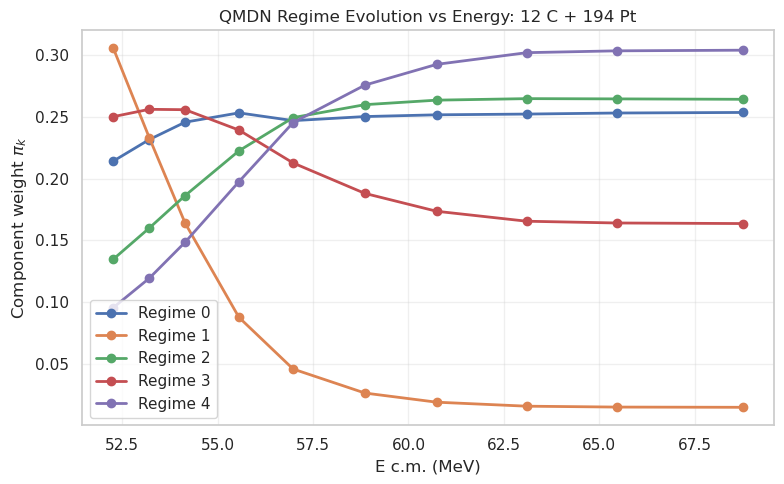

In [48]:
# ========================================================================
# PLOT: QMDN REGIME EVOLUTION FOR A SINGLE REACTION
# ========================================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------
# CHANGE THIS TO ANY REACTION
# ------------------------------------------------
reaction_name = "12 C + 194 Pt"

# ------------------------------------------------
# Make sure:
#   df exists
#   features_train exists
#   scaler exists (the one used in QMDN training)
#   QMDN class is defined
# ------------------------------------------------

# Load trained QMDN model
model = QMDN(in_dim=len(features_train)).to(DEVICE)
model.load_state_dict(torch.load("qmdn_entropy_best.pth", map_location=DEVICE))
model.eval()

# ------------------------------------------------
# Select reaction rows
# ------------------------------------------------
rows_R = df[df["Reaction"] == reaction_name].copy()
rows_R = rows_R.sort_values("E c.m.").reset_index(drop=True)

X_R = rows_R[features_train].values.astype(np.float32)
E_R = rows_R["E c.m."].values

# Scale using QMDN scaler
X_Rs = scaler.transform(X_R)

# ------------------------------------------------
# Forward pass
# ------------------------------------------------
with torch.no_grad():
    xb = torch.tensor(X_Rs, dtype=torch.float32).to(DEVICE)
    pi, mu, sigma = model(xb)
    pi = pi.cpu().numpy()

# ------------------------------------------------
# Plot π_k(E)
# ------------------------------------------------
plt.figure(figsize=(8,5))

for k in range(pi.shape[1]):
    plt.plot(E_R, pi[:,k], marker='o', linewidth=2, label=f"Regime {k}")

plt.xlabel("E c.m. (MeV)")
plt.ylabel("Component weight $\\pi_k$")
plt.title(f"QMDN Regime Evolution vs Energy: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

filename = f"qmdn_regime_evolution_{reaction_name.replace(' ', '_').replace('+', 'plus')}.png"
plt.savefig(filename, dpi=1000)

plt.show()


⭐ QMDN Test Results (Expectation Mode)
RMSE_delta = 0.2507
R2_delta   = -0.3409
RMSE_logσ  = 0.2507
R2_logσ    = 0.9591


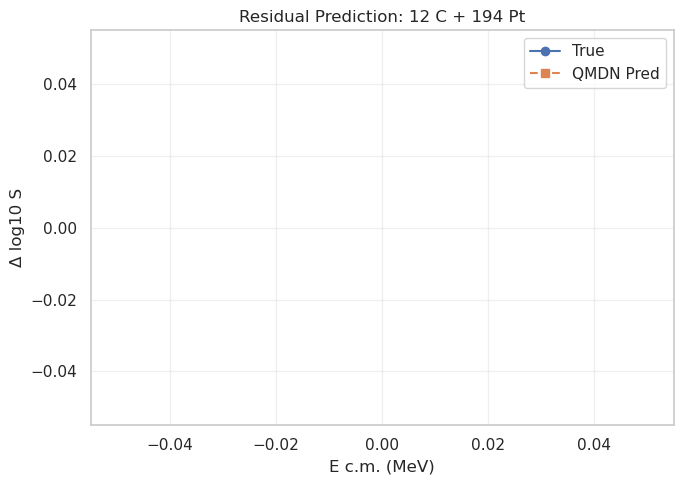

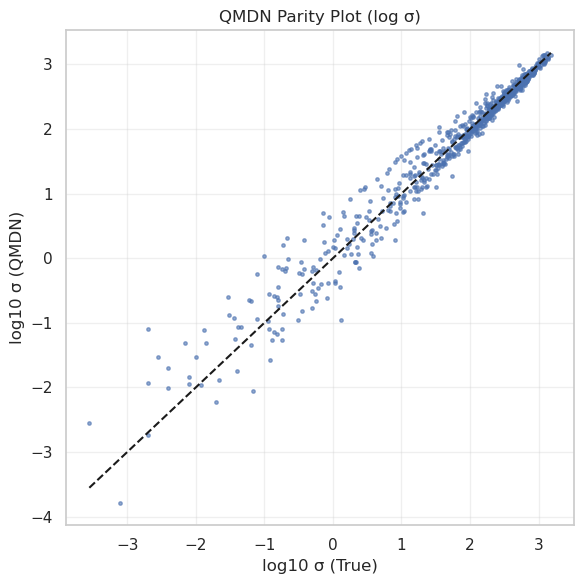

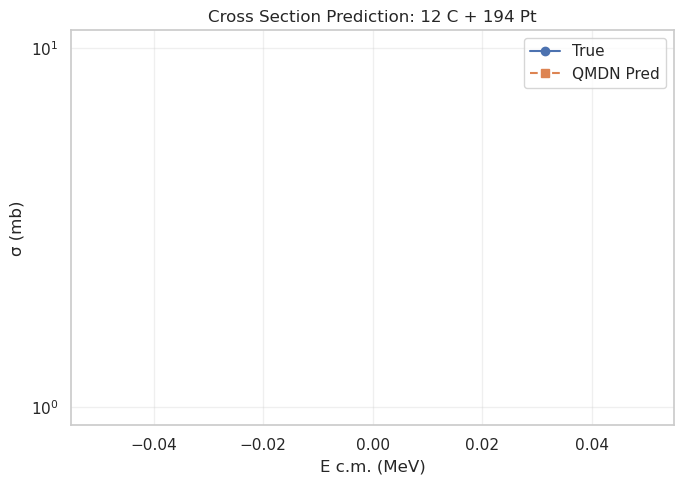

In [49]:
# ==============================================================
# QMDN FULL PREDICTION + CONVERSION + DIAGNOSTIC PLOTS
# ==============================================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------------------------
# Load trained QMDN model
# --------------------------------------------------------------
model = QMDN(in_dim=len(features_train)).to(DEVICE)
model.load_state_dict(torch.load("qmdn_entropy_best.pth", map_location=DEVICE))
model.eval()

# --------------------------------------------------------------
# Prepare test set (must match training split)
# --------------------------------------------------------------
BASE_DIR = "mdn_70_10_20_optimized"

train_reacts = pd.read_csv(f"{BASE_DIR}/train_reactions.csv")["Reaction"].values
val_reacts   = pd.read_csv(f"{BASE_DIR}/val_reactions.csv")["Reaction"].values
test_reacts  = pd.read_csv(f"{BASE_DIR}/test_reactions.csv")["Reaction"].values

test_mask = df["Reaction"].isin(test_reacts)

X_test = df.loc[test_mask, features_train].values.astype(np.float32)
y_test = df.loc[test_mask, "delta_log10_S"].values.astype(np.float32)

test_rows = df.loc[test_mask].reset_index(drop=True)

# Scale with same scaler used in QMDN training
X_test_s = scaler.transform(X_test)

# --------------------------------------------------------------
# QMDN Inference (Expectation Mode)
# --------------------------------------------------------------
preds = []

with torch.no_grad():
    for i in range(0, len(X_test_s), 64):
        xb = torch.tensor(X_test_s[i:i+64], dtype=torch.float32).to(DEVICE)
        pi, mu, sigma = model(xb)

        # EXPECTED VALUE over mixture
        y_pred = (pi * mu).sum(dim=1).cpu().numpy()
        preds.append(y_pred)

y_pred_delta = np.concatenate(preds)

# --------------------------------------------------------------
# Reconstruct log10 S and sigma
# --------------------------------------------------------------
LN10 = np.log(10.0)

test_eta = test_rows["eta"].values
test_Ecm = test_rows["E c.m."].values
log10_S_cal = test_rows["log10_S_cal"].values
sigma_true = test_rows["σ"].values

log10_S_pred = log10_S_cal + y_pred_delta

log10_sigma_pred = (
    log10_S_pred
    - np.log10(np.clip(test_Ecm,1e-30,np.inf))
    - (2*np.pi*test_eta)/LN10
)

sigma_pred = 10**(log10_sigma_pred)

# --------------------------------------------------------------
# Metrics
# --------------------------------------------------------------
rmse_delta = np.sqrt(mean_squared_error(y_test, y_pred_delta))
r2_delta   = r2_score(y_test, y_pred_delta)

rmse_log = np.sqrt(mean_squared_error(
    np.log10(sigma_true+1e-30),
    log10_sigma_pred
))
r2_log = r2_score(
    np.log10(sigma_true+1e-30),
    log10_sigma_pred
)

print("\n⭐ QMDN Test Results (Expectation Mode)")
print(f"RMSE_delta = {rmse_delta:.4f}")
print(f"R2_delta   = {r2_delta:.4f}")
print(f"RMSE_logσ  = {rmse_log:.4f}")
print(f"R2_logσ    = {r2_log:.4f}")

# ==============================================================
# PLOT 1 — Δlog10S vs Energy (One Reaction Example)
# ==============================================================

reaction_name = "12 C + 194 Pt"

mask_R = test_rows["Reaction"] == reaction_name
E_R = test_rows[mask_R]["E c.m."].values
delta_true_R = y_test[mask_R]
delta_pred_R = y_pred_delta[mask_R]

plt.figure(figsize=(7,5))
plt.plot(E_R, delta_true_R, 'o-', label="True")
plt.plot(E_R, delta_pred_R, 's--', label="QMDN Pred")
plt.xlabel("E c.m. (MeV)")
plt.ylabel("Δ log10 S")
plt.title(f"Residual Prediction: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================
# PLOT 2 — logσ Parity Plot
# ==============================================================

plt.figure(figsize=(6,6))

true_log = np.log10(sigma_true+1e-30)

plt.scatter(true_log, log10_sigma_pred, s=6, alpha=0.6)
plt.plot([true_log.min(), true_log.max()],
         [true_log.min(), true_log.max()],
         'k--')

plt.xlabel("log10 σ (True)")
plt.ylabel("log10 σ (QMDN)")
plt.title("QMDN Parity Plot (log σ)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ==============================================================
# PLOT 3 — σ(E) Curve for One Reaction
# ==============================================================

sigma_true_R = sigma_true[mask_R]
sigma_pred_R = sigma_pred[mask_R]

plt.figure(figsize=(7,5))
plt.semilogy(E_R, sigma_true_R, 'o-', label="True")
plt.semilogy(E_R, sigma_pred_R, 's--', label="QMDN Pred")
plt.xlabel("E c.m. (MeV)")
plt.ylabel("σ (mb)")
plt.title(f"Cross Section Prediction: {reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

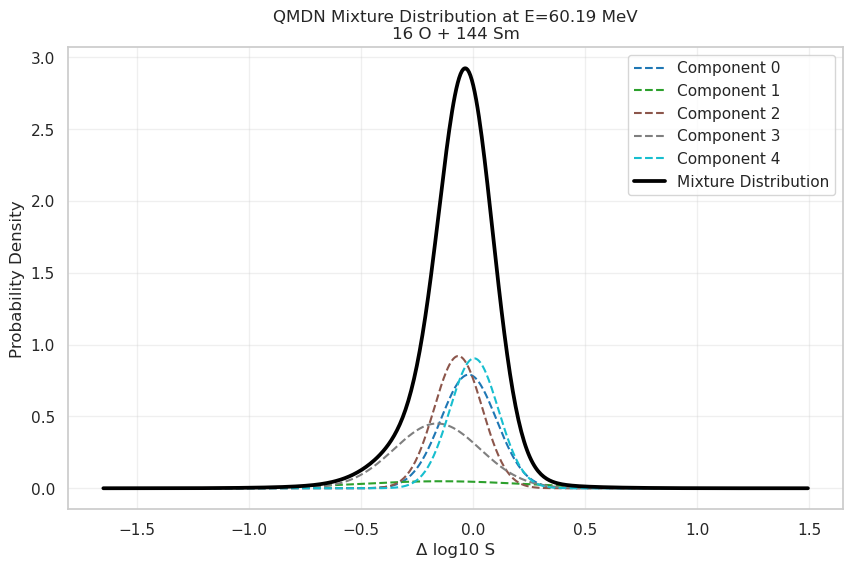

In [50]:
# ==============================================================
# QMDN MIXTURE DISTRIBUTION PLOT (Single Energy)
# ==============================================================

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# USER INPUT
# -----------------------------
reaction_name = "16 O + 144 Sm"
Ecm_value = 60.0   # <-- use a realistic energy inside dataset

# -----------------------------
# Load dataset (df must exist if already loaded)
# -----------------------------
df = pd.read_csv("https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI")

# -----------------------------
# Rebuild physics features (same as training)
# -----------------------------
M_p = 938.272088
M_n = 939.565420
epsilon = 1e-30

def mass(Z,A): return Z*M_p + (A-Z)*M_n

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]

df["mass1"] = mass(df["Z1"], df["A1"])
df["mass2"] = mass(df["Z2"], df["A2"])

mu_red = (df["mass1"] * df["mass2"]) / (df["mass1"] + df["mass2"] + 1e-12)
v_over_c = np.sqrt(np.clip(2*df["E c.m."].values / (mu_red + epsilon), 0, np.inf))
df["eta"] = (df["Z1"] * df["Z2"]) / ((1/137.036) * (v_over_c+1e-16))

df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
df["magic_dist_Z1"] = np.min(np.abs(df["Z1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N1"] = np.min(np.abs(df["N1"].values[:,None] - MAGIC), axis=1)
df["magic_dist_Z2"] = np.min(np.abs(df["Z2"].values[:,None] - MAGIC), axis=1)
df["magic_dist_N2"] = np.min(np.abs(df["N2"].values[:,None] - MAGIC), axis=1)

# -----------------------------
# Feature list (must match training)
# -----------------------------
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm','magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual','Target_Mass_Actual','Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]

# -----------------------------
# Select closest energy row
# -----------------------------
df_r = df[df["Reaction"] == reaction_name].copy()
row = df_r.iloc[(df_r["E c.m."] - Ecm_value).abs().argmin()]

x = row[features_train].values.astype(np.float32).reshape(1,-1)

# -----------------------------
# Load QMDN model
# -----------------------------
model = QMDN(in_dim=len(features_train)).to(DEVICE)
model.load_state_dict(torch.load("qmdn_entropy_best.pth", map_location=DEVICE))
model.eval()

# -----------------------------
# Load QMDN scaler (IMPORTANT)
# -----------------------------
scaler = StandardScaler().fit(df[features_train].values.astype(np.float32))
x_s = scaler.transform(x)

# -----------------------------
# Forward pass
# -----------------------------
with torch.no_grad():
    xb = torch.tensor(x_s, dtype=torch.float32).to(DEVICE)
    pi, mu, sigma = model(xb)

pi = pi.cpu().numpy().flatten()
mu = mu.cpu().numpy().flatten()
sigma = sigma.cpu().numpy().flatten()

# -----------------------------
# Gaussian helper
# -----------------------------
def gaussian(x, m, s):
    return (1/(np.sqrt(2*np.pi)*s))*np.exp(-0.5*((x-m)/s)**2)

# -----------------------------
# Plot mixture
# -----------------------------
xmin = mu.min() - 4*sigma.max()
xmax = mu.max() + 4*sigma.max()
xs = np.linspace(xmin, xmax, 500)

plt.figure(figsize=(10,6))
K = len(pi)
colors = plt.cm.tab10(np.linspace(0,1,K))

for k in range(K):
    ys = pi[k] * gaussian(xs, mu[k], sigma[k])
    plt.plot(xs, ys, "--", color=colors[k], label=f"Component {k}")

ys_mix = np.sum([pi[k]*gaussian(xs,mu[k],sigma[k]) for k in range(K)], axis=0)
plt.plot(xs, ys_mix, color="black", linewidth=2.7, label="Mixture Distribution")

plt.xlabel("Δ log10 S")
plt.ylabel("Probability Density")
plt.title(f"QMDN Mixture Distribution at E={row['E c.m.']:.2f} MeV\n{reaction_name}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()